# Imports and configs

In [1]:
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.metrics import roc_curve, auc
from torch.utils.data import DataLoader, Dataset
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.nn.functional as F
import albumentations as A
import seaborn as sns
from tqdm import tqdm
from PIL import Image
import torch.nn as nn
import pandas as pd
import numpy as np
import warnings
import h5py
import torch
import random
import timm
import cv2
import io
import os
import gc

warnings.filterwarnings('ignore')

In [2]:
class CFG:
    train_metadata_path = '/kaggle/input/isic-2024-challenge/train-metadata.csv'
    test_metadata_path = '/kaggle/input/isic-2024-challenge/test-metadata.csv'
    train_img_path = '/kaggle/input/isic-2024-challenge/train-image.hdf5'
    test_img_path = '/kaggle/input/isic-2024-challenge/test-image.hdf5'
    sample_sub_path = '/kaggle/input/isic-2024-challenge/sample_submission.csv'
    checkpoint_path = '/kaggle/working/checkpoints'

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    max_epochs = 50
    learning_rate = 1e-5
    train_batch_size = 32
    val_batch_size = 64
    n_folds = 5
    seed = 35555
    model_name = "swin_base_patch4_window7_224"
    es_patience = 10

In [3]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(CFG.seed)

# Loading and splitting the datasets

In [4]:
train_metadata = pd.read_csv(CFG.train_metadata_path)

positives = train_metadata[train_metadata.target == 1]
negatives = train_metadata[train_metadata.target == 0]
train_metadata = pd.concat([positives, negatives.sample(n=20 * len(positives), random_state=CFG.seed)])
train_metadata = train_metadata.sample(frac=1, random_state=CFG.seed).reset_index(drop=True)

In [5]:
sgkf = StratifiedGroupKFold(n_splits=CFG.n_folds, random_state=CFG.seed, shuffle=True)
split = sgkf.split(train_metadata, train_metadata.target, groups=train_metadata.patient_id)
for i, (_, val_index) in enumerate(split):
    train_metadata.loc[val_index, 'fold'] = i

In [6]:
train_metadata2 = pd.read_csv(CFG.train_metadata_path)

sgkf = StratifiedGroupKFold(n_splits=CFG.n_folds, random_state=CFG.seed, shuffle=True)
split = sgkf.split(train_metadata2, train_metadata2.target, groups=train_metadata2.patient_id)
for i, (_, val_index) in enumerate(split):
    train_metadata2.loc[val_index, 'fold'] = i

# Creating a custom image dataset

In [7]:
class ISICDataset(Dataset):
    def __init__(self, data_path, metadata, transform=None):
        self.data = h5py.File(data_path, 'r')
        self.metadata = metadata
        self.transform = transform

    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, idx):
        img_name = self.metadata.iloc[idx]['isic_id']
        image = np.array(self.data[img_name])
        image = np.array(Image.open(io.BytesIO(image)), dtype=np.float32)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']

        if 'target' in self.metadata.columns:
            label = int(self.metadata['target'].iloc[idx])
            return image, label
        else:
            return image, 0

In [8]:
# Reference: https://www.kaggle.com/code/qiaoyingzhang/isic-2024-pytorch-training-baseline-swin#Data-Augmentation-&-Helper-Functions

transforms = {
    'train': A.Compose([
        A.RandomRotate90(p=0.5),
        A.Flip(p=0.5),
        A.Transpose(p=0.5),
        A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=45, p=0.5),
        A.OneOf([
            A.HueSaturationValue(p=0.5),
            A.RandomBrightnessContrast(p=0.5),
        ], p=0.5),
        A.OneOf([
            A.GaussNoise(p=0.5),
            A.GaussianBlur(p=0.5),
            A.MotionBlur(p=0.5),
        ], p=0.5),
        A.Resize(224, 224),
        A.Normalize(
            mean=[0.4815, 0.4578, 0.4082], 
            std=[0.2686, 0.2613, 0.2758], 
            max_pixel_value=255.0),
        ToTensorV2(),
    ]),
    
    'val': A.Compose([
        A.Resize(224, 224),
        A.Normalize(
            mean=[0.4815, 0.4578, 0.4082], 
            std=[0.2686, 0.2613, 0.2758], 
            max_pixel_value=255.0),
        ToTensorV2(),
    ])
}

# Customizing the image model

In [9]:
class SwinTransformer(nn.Module):
    def __init__(self, model_name, num_classes=2, pretrained=True):
        super(SwinTransformer, self).__init__()
        self.model = timm.create_model(model_name, pretrained=pretrained, in_chans=3)
        self.model.head = nn.Sequential(
            nn.Flatten(),
            nn.Linear(self.model.num_features * 7 * 7, num_classes)
        )

    def forward(self, x):
        return self.model(x)

# Creating a trainer class

In [10]:
class Trainer:
    def __init__(
        self,
        device,
        model,
        criterion,
        optimizer,
        scheduler,
        train_dataloader,
        val_dataloader,
        checkpoint_path,
        fold_idx,
        es_patience
    ):
        self.device = device
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.train_dataloader = train_dataloader
        self.val_dataloader = val_dataloader
        self.checkpoint_path = checkpoint_path
        self.best_pauc = 0.0
        self.best_model_path = None
        self.fold_idx = fold_idx
        self.es_patience = es_patience
        self.create_checkpoint_path()

    def create_checkpoint_path(self):
        if not os.path.exists(self.checkpoint_path):
            os.makedirs(self.checkpoint_path)

    @staticmethod
    def p_roc_auc_score(y_true, y_preds, min_tpr: float = 0.80):
        v_gt = abs(np.asarray(y_true)-1)
        v_pred = -1.0 * np.asarray(y_preds)
        max_fpr = abs(1-min_tpr)
        fpr, tpr, _ = roc_curve(v_gt, v_pred, sample_weight=None)
        if max_fpr is None or max_fpr == 1:
            return auc(fpr, tpr)
        if max_fpr <= 0 or max_fpr > 1:
            raise ValueError("Expected min_tpr in range [0, 1), got: %r" % min_tpr)
        stop = np.searchsorted(fpr, max_fpr, "right")
        x_interp = [fpr[stop - 1], fpr[stop]]
        y_interp = [tpr[stop - 1], tpr[stop]]
        tpr = np.append(tpr[:stop], np.interp(max_fpr, x_interp, y_interp))
        fpr = np.append(fpr[:stop], max_fpr)
        partial_auc = auc(fpr, tpr)
        return partial_auc

    def train(self, current_epoch_nr):
        self.model.train()

        num_batches = len(self.train_dataloader)

        running_loss = 0.0
        total = 0

        preds = []
        targets = []

        loop = tqdm(self.train_dataloader, total=num_batches)
        for batch in loop:
            x, y = batch
            x, y = x.to(self.device), y.to(self.device)

            self.optimizer.zero_grad()

            y_hat = self.model(x)
            pred_probs = F.softmax(y_hat, dim=1)

            preds.extend(pred_probs[:, 1].detach().cpu().numpy())
            targets.extend(y.detach().cpu().numpy())

            loss = self.criterion(y_hat, y)
            loss.backward()
            self.optimizer.step()

            running_loss += loss.item() * x.size(0)
            total += y.size(0)

            loop.set_description(f'Epoch {current_epoch_nr}')
            loop.set_postfix(train_loss=round(running_loss / total, 6))

            if self.scheduler is not None:
                self.scheduler.step()

        train_pauc = self.p_roc_auc_score(targets, preds)
        train_loss = running_loss / num_batches

        return train_pauc, train_loss

    def evaluate(self, current_epoch_nr):
        self.model.eval()

        num_batches = len(self.val_dataloader)

        running_loss = 0.0
        total = 0

        preds = []
        targets = []

        with torch.no_grad():
            loop = tqdm(self.val_dataloader, total=num_batches)
            for batch in loop:
                x, y = batch
                x, y = x.to(self.device), y.to(self.device)

                self.optimizer.zero_grad()

                y_hat = self.model(x)
                pred_probs = F.softmax(y_hat, dim=1)

                preds.extend(pred_probs[:, 1].detach().cpu().numpy())
                targets.extend(y.detach().cpu().numpy())

                loss = self.criterion(y_hat, y)
                running_loss += loss.item() * x.size(0)
                total += y.size(0)

                loop.set_description(f'Epoch {current_epoch_nr}')
                loop.set_postfix(val_loss=round(running_loss / total, 6))

        val_pauc = self.p_roc_auc_score(targets, preds)
        val_loss = running_loss / num_batches

        if val_pauc > self.best_pauc:
            self.es_patience = CFG.es_patience
            if self.best_pauc != 0.0:
                print(f'New best model found: pAUC = {val_pauc:.6f} (previous best: {self.best_pauc:.6f})')
            self.best_pauc = val_pauc
            checkpoint_name = f'fold_{self.fold_idx}_epoch_{current_epoch_nr}_pauc_{round(val_pauc, 6)}.pth'

            for file in os.listdir(self.checkpoint_path):
                if file.startswith(f'fold_{self.fold_idx}_epoch_'):
                    os.remove(os.path.join(self.checkpoint_path, file))

            torch.save(
                self.model.state_dict(),
                os.path.join(self.checkpoint_path, checkpoint_name)
            )
            self.best_model_path = os.path.join(
                self.checkpoint_path, checkpoint_name)

        else:
            self.es_patience -= 1
            if self.es_patience == 0:
                print(f'Early stopping triggered at epoch {current_epoch_nr}. Best pAUC = {self.best_pauc:.6f}')
                return val_pauc, val_loss, True

        return val_pauc, val_loss, False

    def predict(self, dataloader):
        model = self.model.to(self.device)
        model.load_state_dict(torch.load(self.best_model_path))
        model.eval()

        preds = []
        with torch.no_grad():
            loop = tqdm(dataloader, total=len(dataloader))
            for batch in loop:
                x, _ = batch
                x = x.to(self.device)
                y_hat = model(x)
                pred_probs = F.softmax(y_hat, dim=1)
                preds.extend(pred_probs.detach().cpu().numpy())
                loop.set_description(f'Prediction')

        return preds

# Training and cross-validation

In [11]:
histories = {}
oof_pred_probs_df = []

for fold_idx in range(CFG.n_folds):
    print(f'---------------------------------- Fold {fold_idx + 1} ----------------------------------')

    _train = train_metadata[train_metadata['fold'] != fold_idx]
    train_dataset = ISICDataset(CFG.train_img_path, _train, transforms['train'])
    train_dataloader = DataLoader(train_dataset, batch_size=CFG.train_batch_size, shuffle=True,  num_workers=4)

    _val = train_metadata[train_metadata['fold'] == fold_idx]
    val_dataset = ISICDataset(CFG.train_img_path, _val, transforms['val'])
    val_dataloader = DataLoader(val_dataset, batch_size=CFG.val_batch_size, shuffle=False, num_workers=4)

    _val2 = train_metadata2[train_metadata2['fold'] == fold_idx]
    val_dataset2 = ISICDataset(CFG.train_img_path, _val2, transforms['val'])
    val_dataloader2 = DataLoader(val_dataset2, batch_size=CFG.val_batch_size, shuffle=False, num_workers=4)

    model = SwinTransformer(CFG.model_name).to(CFG.device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=CFG.learning_rate)
    t_max = len(train_dataloader) * CFG.max_epochs
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=t_max, eta_min=1e-10)

    trainer = Trainer(
        device=CFG.device,
        model=model,
        criterion=criterion,
        optimizer=optimizer,
        scheduler=scheduler,
        train_dataloader=train_dataloader,
        val_dataloader=val_dataloader,
        checkpoint_path=CFG.checkpoint_path,
        fold_idx=fold_idx,
        es_patience=CFG.es_patience
    )

    history = {
        'epoch': [],
        'train_pauc': [],
        'train_loss': [],
        'val_pauc': [],
        'val_loss': []
    }
    for epoch in range(1, CFG.max_epochs + 1):
        train_pauc, train_loss = trainer.train(current_epoch_nr=epoch)
        val_pauc, val_loss, es_triggered = trainer.evaluate(current_epoch_nr=epoch)

        print(f"Epoch {epoch}: Train pAUC: {train_pauc:.6f} - Val pAUC: {val_pauc:.6f} | Train Loss: {train_loss:.6f} - Val Loss: {val_loss:.6f}\n")

        history['epoch'].append(epoch)
        history['train_pauc'].append(train_pauc)
        history['train_loss'].append(train_loss)
        history['val_pauc'].append(val_pauc)
        history['val_loss'].append(val_loss)

        if es_triggered:
            break

    histories[f'Fold {fold_idx + 1}'] = history

    pred_probs = trainer.predict(val_dataloader2)
    cols = ['p0', 'p1']
    _val2[cols] = pred_probs
    oof_pred_probs_df.append(_val2)

    del _train, _val, train_dataset, val_dataset, model, criterion, optimizer, scheduler, trainer
    gc.collect()
    torch.cuda.empty_cache()

    print(f'---------------------------------- Fold {fold_idx + 1} ----------------------------------\n\n')

---------------------------------- Fold 1 ----------------------------------


model.safetensors:   0%|          | 0.00/353M [00:00<?, ?B/s]

Epoch 1: 100%|██████████| 25/25 [00:11<00:00,  2.17it/s, val_loss=0.13]


Epoch 1: Train pAUC: 0.040930 - Val pAUC: 0.098290 | Train Loss: 6.257861 - Val Loss: 8.256366



Epoch 2: 100%|██████████| 25/25 [00:11<00:00,  2.24it/s, val_loss=0.141]


New best model found: pAUC = 0.117972 (previous best: 0.098290)
Epoch 2: Train pAUC: 0.058611 - Val pAUC: 0.117972 | Train Loss: 5.673096 - Val Loss: 8.973595



Epoch 3: 100%|██████████| 25/25 [00:11<00:00,  2.24it/s, val_loss=0.148]


Epoch 3: Train pAUC: 0.064494 - Val pAUC: 0.116096 | Train Loss: 5.547453 - Val Loss: 9.391682



Epoch 4: 100%|██████████| 25/25 [00:11<00:00,  2.23it/s, val_loss=0.139]


New best model found: pAUC = 0.126810 (previous best: 0.117972)
Epoch 4: Train pAUC: 0.072888 - Val pAUC: 0.126810 | Train Loss: 5.381975 - Val Loss: 8.823573



Epoch 5: 100%|██████████| 25/25 [00:11<00:00,  2.23it/s, val_loss=0.116]


New best model found: pAUC = 0.139148 (previous best: 0.126810)
Epoch 5: Train pAUC: 0.070829 - Val pAUC: 0.139148 | Train Loss: 5.424368 - Val Loss: 7.380934



Epoch 6: 100%|██████████| 25/25 [00:11<00:00,  2.23it/s, val_loss=0.124]


Epoch 6: Train pAUC: 0.075243 - Val pAUC: 0.130694 | Train Loss: 5.034362 - Val Loss: 7.854873



Epoch 7: 100%|██████████| 25/25 [00:11<00:00,  2.23it/s, val_loss=0.124]


New best model found: pAUC = 0.140136 (previous best: 0.139148)
Epoch 7: Train pAUC: 0.072768 - Val pAUC: 0.140136 | Train Loss: 5.166187 - Val Loss: 7.884091



Epoch 8: 100%|██████████| 25/25 [00:11<00:00,  2.24it/s, val_loss=0.116]


New best model found: pAUC = 0.147410 (previous best: 0.140136)
Epoch 8: Train pAUC: 0.077392 - Val pAUC: 0.147410 | Train Loss: 5.001734 - Val Loss: 7.364972



Epoch 9: 100%|██████████| 25/25 [00:11<00:00,  2.20it/s, val_loss=0.107]


New best model found: pAUC = 0.161594 (previous best: 0.147410)
Epoch 9: Train pAUC: 0.080755 - Val pAUC: 0.161594 | Train Loss: 5.034613 - Val Loss: 6.784874



Epoch 10: 100%|██████████| 25/25 [00:11<00:00,  2.23it/s, val_loss=0.127]


Epoch 10: Train pAUC: 0.077354 - Val pAUC: 0.154714 | Train Loss: 4.910121 - Val Loss: 8.098278



Epoch 11: 100%|██████████| 25/25 [00:11<00:00,  2.23it/s, val_loss=0.122]


Epoch 11: Train pAUC: 0.084675 - Val pAUC: 0.155874 | Train Loss: 4.842066 - Val Loss: 7.752348



Epoch 12: 100%|██████████| 25/25 [00:11<00:00,  2.23it/s, val_loss=0.117]


Epoch 12: Train pAUC: 0.081195 - Val pAUC: 0.149549 | Train Loss: 5.000847 - Val Loss: 7.459943



Epoch 13: 100%|██████████| 25/25 [00:11<00:00,  2.23it/s, val_loss=0.107]


Epoch 13: Train pAUC: 0.085790 - Val pAUC: 0.148852 | Train Loss: 4.968358 - Val Loss: 6.828837



Epoch 14: 100%|██████████| 25/25 [00:11<00:00,  2.24it/s, val_loss=0.11]


Epoch 14: Train pAUC: 0.085345 - Val pAUC: 0.149155 | Train Loss: 4.833910 - Val Loss: 6.991646



Epoch 15: 100%|██████████| 25/25 [00:11<00:00,  2.24it/s, val_loss=0.122]


Epoch 15: Train pAUC: 0.085762 - Val pAUC: 0.148146 | Train Loss: 4.835133 - Val Loss: 7.733778



Epoch 16: 100%|██████████| 25/25 [00:11<00:00,  2.23it/s, val_loss=0.116]


Epoch 16: Train pAUC: 0.080542 - Val pAUC: 0.151415 | Train Loss: 4.838936 - Val Loss: 7.369252



Epoch 17: 100%|██████████| 25/25 [00:11<00:00,  2.24it/s, val_loss=0.111]


Epoch 17: Train pAUC: 0.082296 - Val pAUC: 0.146784 | Train Loss: 4.741076 - Val Loss: 7.081877



Epoch 18: 100%|██████████| 25/25 [00:11<00:00,  2.23it/s, val_loss=0.108]


Epoch 18: Train pAUC: 0.082199 - Val pAUC: 0.155692 | Train Loss: 4.984258 - Val Loss: 6.851286



Epoch 19: 100%|██████████| 25/25 [00:11<00:00,  2.23it/s, val_loss=0.113]


Early stopping triggered at epoch 19. Best pAUC = 0.161594
Epoch 19: Train pAUC: 0.084278 - Val pAUC: 0.146805 | Train Loss: 4.843409 - Val Loss: 7.200200



Prediction: 100%|██████████| 1211/1211 [08:37<00:00,  2.34it/s]


---------------------------------- Fold 1 ----------------------------------


---------------------------------- Fold 2 ----------------------------------


Epoch 1: 100%|██████████| 29/29 [00:12<00:00,  2.26it/s, val_loss=0.13]


Epoch 1: Train pAUC: 0.029794 - Val pAUC: 0.107479 | Train Loss: 6.593627 - Val Loss: 8.221131



Epoch 2: 100%|██████████| 29/29 [00:12<00:00,  2.26it/s, val_loss=0.103]


New best model found: pAUC = 0.138363 (previous best: 0.107479)
Epoch 2: Train pAUC: 0.056213 - Val pAUC: 0.138363 | Train Loss: 5.826500 - Val Loss: 6.521438



Epoch 3: 100%|██████████| 29/29 [00:12<00:00,  2.26it/s, val_loss=0.0975]


New best model found: pAUC = 0.146948 (previous best: 0.138363)
Epoch 3: Train pAUC: 0.068179 - Val pAUC: 0.146948 | Train Loss: 5.544945 - Val Loss: 6.145171



Epoch 4: 100%|██████████| 29/29 [00:12<00:00,  2.25it/s, val_loss=0.11]


New best model found: pAUC = 0.155527 (previous best: 0.146948)
Epoch 4: Train pAUC: 0.072347 - Val pAUC: 0.155527 | Train Loss: 5.457829 - Val Loss: 6.930209



Epoch 5: 100%|██████████| 29/29 [00:12<00:00,  2.26it/s, val_loss=0.0905]


Epoch 5: Train pAUC: 0.077590 - Val pAUC: 0.154838 | Train Loss: 5.196335 - Val Loss: 5.705998



Epoch 6: 100%|██████████| 29/29 [00:12<00:00,  2.26it/s, val_loss=0.0929]


Epoch 6: Train pAUC: 0.075620 - Val pAUC: 0.153085 | Train Loss: 5.005445 - Val Loss: 5.858650



Epoch 7: 100%|██████████| 29/29 [00:12<00:00,  2.25it/s, val_loss=0.0911]


Epoch 7: Train pAUC: 0.076345 - Val pAUC: 0.144746 | Train Loss: 5.216997 - Val Loss: 5.743774



Epoch 8: 100%|██████████| 29/29 [00:12<00:00,  2.26it/s, val_loss=0.0787]


New best model found: pAUC = 0.159062 (previous best: 0.155527)
Epoch 8: Train pAUC: 0.076207 - Val pAUC: 0.159062 | Train Loss: 5.265836 - Val Loss: 4.958847



Epoch 9: 100%|██████████| 29/29 [00:12<00:00,  2.26it/s, val_loss=0.0917]


Epoch 9: Train pAUC: 0.083677 - Val pAUC: 0.154091 | Train Loss: 4.978721 - Val Loss: 5.780424



Epoch 10: 100%|██████████| 29/29 [00:12<00:00,  2.27it/s, val_loss=0.0881]


Epoch 10: Train pAUC: 0.080599 - Val pAUC: 0.154917 | Train Loss: 5.064829 - Val Loss: 5.556096



Epoch 11: 100%|██████████| 29/29 [00:12<00:00,  2.26it/s, val_loss=0.102]


Epoch 11: Train pAUC: 0.083125 - Val pAUC: 0.147172 | Train Loss: 4.838175 - Val Loss: 6.449054



Epoch 12: 100%|██████████| 29/29 [00:12<00:00,  2.26it/s, val_loss=0.0918]


Epoch 12: Train pAUC: 0.083479 - Val pAUC: 0.150835 | Train Loss: 5.105596 - Val Loss: 5.788306



Epoch 13: 100%|██████████| 29/29 [00:13<00:00,  2.22it/s, val_loss=0.0837]


New best model found: pAUC = 0.159584 (previous best: 0.159062)
Epoch 13: Train pAUC: 0.085615 - Val pAUC: 0.159584 | Train Loss: 4.883789 - Val Loss: 5.273936



Epoch 14: 100%|██████████| 29/29 [00:12<00:00,  2.27it/s, val_loss=0.0869]


Epoch 14: Train pAUC: 0.091199 - Val pAUC: 0.156521 | Train Loss: 4.726853 - Val Loss: 5.478805



Epoch 15: 100%|██████████| 29/29 [00:12<00:00,  2.27it/s, val_loss=0.0836]


Epoch 15: Train pAUC: 0.084620 - Val pAUC: 0.153116 | Train Loss: 4.859136 - Val Loss: 5.270330



Epoch 16: 100%|██████████| 29/29 [00:12<00:00,  2.28it/s, val_loss=0.0924]


Epoch 16: Train pAUC: 0.085845 - Val pAUC: 0.141413 | Train Loss: 4.666113 - Val Loss: 5.823980



Epoch 17: 100%|██████████| 29/29 [00:12<00:00,  2.26it/s, val_loss=0.0873]


Epoch 17: Train pAUC: 0.087031 - Val pAUC: 0.155774 | Train Loss: 4.684801 - Val Loss: 5.501806



Epoch 18: 100%|██████████| 29/29 [00:13<00:00,  2.23it/s, val_loss=0.0975]


Epoch 18: Train pAUC: 0.089993 - Val pAUC: 0.155170 | Train Loss: 4.668007 - Val Loss: 6.146062



Epoch 19: 100%|██████████| 29/29 [00:12<00:00,  2.27it/s, val_loss=0.0906]


Epoch 19: Train pAUC: 0.086569 - Val pAUC: 0.155475 | Train Loss: 4.692766 - Val Loss: 5.709024



Epoch 20: 100%|██████████| 29/29 [00:12<00:00,  2.26it/s, val_loss=0.0838]


New best model found: pAUC = 0.163099 (previous best: 0.159584)
Epoch 20: Train pAUC: 0.087294 - Val pAUC: 0.163099 | Train Loss: 4.679108 - Val Loss: 5.280661



Epoch 21: 100%|██████████| 29/29 [00:12<00:00,  2.26it/s, val_loss=0.0842]


Epoch 21: Train pAUC: 0.092676 - Val pAUC: 0.162757 | Train Loss: 4.622547 - Val Loss: 5.307683



Epoch 22: 100%|██████████| 29/29 [00:12<00:00,  2.27it/s, val_loss=0.086]


Epoch 22: Train pAUC: 0.094098 - Val pAUC: 0.161745 | Train Loss: 4.573633 - Val Loss: 5.423027



Epoch 23: 100%|██████████| 29/29 [00:12<00:00,  2.26it/s, val_loss=0.087]


Epoch 23: Train pAUC: 0.092117 - Val pAUC: 0.158814 | Train Loss: 4.646805 - Val Loss: 5.483983



Epoch 24: 100%|██████████| 29/29 [00:12<00:00,  2.25it/s, val_loss=0.0877]


Epoch 24: Train pAUC: 0.087973 - Val pAUC: 0.156823 | Train Loss: 4.526981 - Val Loss: 5.528867



Epoch 25: 100%|██████████| 29/29 [00:12<00:00,  2.27it/s, val_loss=0.087]


Epoch 25: Train pAUC: 0.091914 - Val pAUC: 0.157510 | Train Loss: 4.415640 - Val Loss: 5.486142



Epoch 26: 100%|██████████| 29/29 [00:12<00:00,  2.27it/s, val_loss=0.11]


Epoch 26: Train pAUC: 0.092143 - Val pAUC: 0.155677 | Train Loss: 4.507255 - Val Loss: 6.944996



Epoch 27: 100%|██████████| 29/29 [00:12<00:00,  2.26it/s, val_loss=0.0849]


New best model found: pAUC = 0.167341 (previous best: 0.163099)
Epoch 27: Train pAUC: 0.094795 - Val pAUC: 0.167341 | Train Loss: 4.366434 - Val Loss: 5.351746



Epoch 28: 100%|██████████| 29/29 [00:12<00:00,  2.27it/s, val_loss=0.0939]


Epoch 28: Train pAUC: 0.093199 - Val pAUC: 0.161885 | Train Loss: 4.354452 - Val Loss: 5.918208



Epoch 29: 100%|██████████| 29/29 [00:12<00:00,  2.26it/s, val_loss=0.0924]


Epoch 29: Train pAUC: 0.101890 - Val pAUC: 0.159533 | Train Loss: 4.197837 - Val Loss: 5.822047



Epoch 30: 100%|██████████| 29/29 [00:12<00:00,  2.27it/s, val_loss=0.0906]


Epoch 30: Train pAUC: 0.097059 - Val pAUC: 0.162355 | Train Loss: 4.190019 - Val Loss: 5.708566



Epoch 31: 100%|██████████| 29/29 [00:12<00:00,  2.27it/s, val_loss=0.099]


Epoch 31: Train pAUC: 0.098292 - Val pAUC: 0.157789 | Train Loss: 4.360888 - Val Loss: 6.243498



Epoch 32: 100%|██████████| 29/29 [00:12<00:00,  2.27it/s, val_loss=0.0964]


Epoch 32: Train pAUC: 0.102630 - Val pAUC: 0.161025 | Train Loss: 4.088972 - Val Loss: 6.076250



Epoch 33: 100%|██████████| 29/29 [00:12<00:00,  2.26it/s, val_loss=0.101]


Epoch 33: Train pAUC: 0.101189 - Val pAUC: 0.160466 | Train Loss: 4.154697 - Val Loss: 6.380336



Epoch 34: 100%|██████████| 29/29 [00:12<00:00,  2.25it/s, val_loss=0.115]


Epoch 34: Train pAUC: 0.106814 - Val pAUC: 0.162512 | Train Loss: 4.000829 - Val Loss: 7.255835



Epoch 35: 100%|██████████| 29/29 [00:12<00:00,  2.26it/s, val_loss=0.0998]


Epoch 35: Train pAUC: 0.101619 - Val pAUC: 0.159774 | Train Loss: 4.008536 - Val Loss: 6.292774



Epoch 36: 100%|██████████| 29/29 [00:12<00:00,  2.26it/s, val_loss=0.106]


Epoch 36: Train pAUC: 0.101071 - Val pAUC: 0.156603 | Train Loss: 4.276839 - Val Loss: 6.681470



Epoch 37: 100%|██████████| 29/29 [00:12<00:00,  2.26it/s, val_loss=0.104]


Early stopping triggered at epoch 37. Best pAUC = 0.167341
Epoch 37: Train pAUC: 0.099379 - Val pAUC: 0.157042 | Train Loss: 3.950541 - Val Loss: 6.527862



Prediction: 100%|██████████| 1310/1310 [09:19<00:00,  2.34it/s]


---------------------------------- Fold 2 ----------------------------------


---------------------------------- Fold 3 ----------------------------------


Epoch 1: 100%|██████████| 21/21 [00:09<00:00,  2.26it/s, val_loss=0.167]


Epoch 1: Train pAUC: 0.027265 - Val pAUC: 0.078649 | Train Loss: 6.285912 - Val Loss: 10.378246



Epoch 2: 100%|██████████| 21/21 [00:09<00:00,  2.24it/s, val_loss=0.141]


New best model found: pAUC = 0.142633 (previous best: 0.078649)
Epoch 2: Train pAUC: 0.049792 - Val pAUC: 0.142633 | Train Loss: 5.538953 - Val Loss: 8.737057



Epoch 3: 100%|██████████| 21/21 [00:09<00:00,  2.24it/s, val_loss=0.119]


New best model found: pAUC = 0.150592 (previous best: 0.142633)
Epoch 3: Train pAUC: 0.060752 - Val pAUC: 0.150592 | Train Loss: 5.373040 - Val Loss: 7.415165



Epoch 4: 100%|██████████| 21/21 [00:09<00:00,  2.26it/s, val_loss=0.116]


New best model found: pAUC = 0.152089 (previous best: 0.150592)
Epoch 4: Train pAUC: 0.072723 - Val pAUC: 0.152089 | Train Loss: 5.030961 - Val Loss: 7.197959



Epoch 5: 100%|██████████| 21/21 [00:09<00:00,  2.26it/s, val_loss=0.116]


Epoch 5: Train pAUC: 0.072266 - Val pAUC: 0.152017 | Train Loss: 5.133823 - Val Loss: 7.228395



Epoch 6: 100%|██████████| 21/21 [00:09<00:00,  2.25it/s, val_loss=0.118]


Epoch 6: Train pAUC: 0.076348 - Val pAUC: 0.144979 | Train Loss: 4.953937 - Val Loss: 7.361530



Epoch 7: 100%|██████████| 21/21 [00:09<00:00,  2.26it/s, val_loss=0.129]


Epoch 7: Train pAUC: 0.073210 - Val pAUC: 0.137287 | Train Loss: 5.082779 - Val Loss: 8.045815



Epoch 8: 100%|██████████| 21/21 [00:09<00:00,  2.25it/s, val_loss=0.116]


New best model found: pAUC = 0.155774 (previous best: 0.152089)
Epoch 8: Train pAUC: 0.076379 - Val pAUC: 0.155774 | Train Loss: 5.041096 - Val Loss: 7.208906



Epoch 9: 100%|██████████| 21/21 [00:09<00:00,  2.25it/s, val_loss=0.122]


Epoch 9: Train pAUC: 0.077291 - Val pAUC: 0.142625 | Train Loss: 4.844033 - Val Loss: 7.601840



Epoch 10: 100%|██████████| 21/21 [00:09<00:00,  2.25it/s, val_loss=0.155]


Epoch 10: Train pAUC: 0.081667 - Val pAUC: 0.146023 | Train Loss: 4.866996 - Val Loss: 9.630248



Epoch 11: 100%|██████████| 21/21 [00:09<00:00,  2.23it/s, val_loss=0.124]


Epoch 11: Train pAUC: 0.083441 - Val pAUC: 0.149254 | Train Loss: 4.912595 - Val Loss: 7.707639



Epoch 12: 100%|██████████| 21/21 [00:09<00:00,  2.27it/s, val_loss=0.106]


New best model found: pAUC = 0.157534 (previous best: 0.155774)
Epoch 12: Train pAUC: 0.078139 - Val pAUC: 0.157534 | Train Loss: 4.931622 - Val Loss: 6.603936



Epoch 13: 100%|██████████| 21/21 [00:09<00:00,  2.27it/s, val_loss=0.104]


New best model found: pAUC = 0.158554 (previous best: 0.157534)
Epoch 13: Train pAUC: 0.080277 - Val pAUC: 0.158554 | Train Loss: 4.797416 - Val Loss: 6.457917



Epoch 14: 100%|██████████| 21/21 [00:09<00:00,  2.25it/s, val_loss=0.114]


Epoch 14: Train pAUC: 0.078240 - Val pAUC: 0.153755 | Train Loss: 4.803065 - Val Loss: 7.054672



Epoch 15: 100%|██████████| 21/21 [00:09<00:00,  2.26it/s, val_loss=0.103]


New best model found: pAUC = 0.160637 (previous best: 0.158554)
Epoch 15: Train pAUC: 0.080905 - Val pAUC: 0.160637 | Train Loss: 4.842803 - Val Loss: 6.383469



Epoch 16: 100%|██████████| 21/21 [00:09<00:00,  2.26it/s, val_loss=0.115]


Epoch 16: Train pAUC: 0.076455 - Val pAUC: 0.144677 | Train Loss: 4.668881 - Val Loss: 7.169396



Epoch 17: 100%|██████████| 21/21 [00:09<00:00,  2.27it/s, val_loss=0.12]


Epoch 17: Train pAUC: 0.090146 - Val pAUC: 0.138365 | Train Loss: 4.617701 - Val Loss: 7.434224



Epoch 18: 100%|██████████| 21/21 [00:09<00:00,  2.26it/s, val_loss=0.122]


Epoch 18: Train pAUC: 0.092441 - Val pAUC: 0.142594 | Train Loss: 4.556341 - Val Loss: 7.582045



Epoch 19: 100%|██████████| 21/21 [00:09<00:00,  2.26it/s, val_loss=0.117]


Epoch 19: Train pAUC: 0.088250 - Val pAUC: 0.144610 | Train Loss: 4.731077 - Val Loss: 7.272406



Epoch 20: 100%|██████████| 21/21 [00:09<00:00,  2.26it/s, val_loss=0.113]


Epoch 20: Train pAUC: 0.084527 - Val pAUC: 0.150344 | Train Loss: 4.319491 - Val Loss: 7.038208



Epoch 21: 100%|██████████| 21/21 [00:09<00:00,  2.25it/s, val_loss=0.118]


Epoch 21: Train pAUC: 0.086571 - Val pAUC: 0.149676 | Train Loss: 4.516769 - Val Loss: 7.328855



Epoch 22: 100%|██████████| 21/21 [00:09<00:00,  2.26it/s, val_loss=0.105]


Epoch 22: Train pAUC: 0.084854 - Val pAUC: 0.158028 | Train Loss: 4.559152 - Val Loss: 6.512688



Epoch 23: 100%|██████████| 21/21 [00:09<00:00,  2.26it/s, val_loss=0.107]


Epoch 23: Train pAUC: 0.084398 - Val pAUC: 0.158674 | Train Loss: 4.496190 - Val Loss: 6.618657



Epoch 24: 100%|██████████| 21/21 [00:09<00:00,  2.24it/s, val_loss=0.106]


Epoch 24: Train pAUC: 0.087197 - Val pAUC: 0.157025 | Train Loss: 4.465270 - Val Loss: 6.586890



Epoch 25: 100%|██████████| 21/21 [00:09<00:00,  2.26it/s, val_loss=0.111]


Early stopping triggered at epoch 25. Best pAUC = 0.160637
Epoch 25: Train pAUC: 0.084693 - Val pAUC: 0.155176 | Train Loss: 4.521690 - Val Loss: 6.901576



Prediction: 100%|██████████| 1191/1191 [08:28<00:00,  2.34it/s]


---------------------------------- Fold 3 ----------------------------------


---------------------------------- Fold 4 ----------------------------------


Epoch 1: 100%|██████████| 27/27 [00:11<00:00,  2.25it/s, val_loss=0.139]


Epoch 1: Train pAUC: 0.025862 - Val pAUC: 0.098494 | Train Loss: 6.490809 - Val Loss: 8.763265



Epoch 2: 100%|██████████| 27/27 [00:11<00:00,  2.26it/s, val_loss=0.114]


New best model found: pAUC = 0.151792 (previous best: 0.098494)
Epoch 2: Train pAUC: 0.049629 - Val pAUC: 0.151792 | Train Loss: 5.715987 - Val Loss: 7.216704



Epoch 3: 100%|██████████| 27/27 [00:11<00:00,  2.26it/s, val_loss=0.112]


New best model found: pAUC = 0.155515 (previous best: 0.151792)
Epoch 3: Train pAUC: 0.064603 - Val pAUC: 0.155515 | Train Loss: 5.487322 - Val Loss: 7.052174



Epoch 4: 100%|██████████| 27/27 [00:11<00:00,  2.27it/s, val_loss=0.115]


New best model found: pAUC = 0.164800 (previous best: 0.155515)
Epoch 4: Train pAUC: 0.066942 - Val pAUC: 0.164800 | Train Loss: 5.411505 - Val Loss: 7.236675



Epoch 5: 100%|██████████| 27/27 [00:11<00:00,  2.27it/s, val_loss=0.107]


Epoch 5: Train pAUC: 0.076366 - Val pAUC: 0.153544 | Train Loss: 5.215669 - Val Loss: 6.720627



Epoch 6: 100%|██████████| 27/27 [00:11<00:00,  2.25it/s, val_loss=0.108]


Epoch 6: Train pAUC: 0.075691 - Val pAUC: 0.161803 | Train Loss: 5.153454 - Val Loss: 6.819303



Epoch 7: 100%|██████████| 27/27 [00:11<00:00,  2.26it/s, val_loss=0.103]


New best model found: pAUC = 0.167591 (previous best: 0.164800)
Epoch 7: Train pAUC: 0.070005 - Val pAUC: 0.167591 | Train Loss: 5.293028 - Val Loss: 6.514255



Epoch 8: 100%|██████████| 27/27 [00:12<00:00,  2.22it/s, val_loss=0.0978]


Epoch 8: Train pAUC: 0.080590 - Val pAUC: 0.163644 | Train Loss: 5.071997 - Val Loss: 6.166469



Epoch 9: 100%|██████████| 27/27 [00:11<00:00,  2.25it/s, val_loss=0.102]


Epoch 9: Train pAUC: 0.085953 - Val pAUC: 0.161750 | Train Loss: 5.079486 - Val Loss: 6.410566



Epoch 10: 100%|██████████| 27/27 [00:12<00:00,  2.24it/s, val_loss=0.102]


Epoch 10: Train pAUC: 0.078680 - Val pAUC: 0.160346 | Train Loss: 5.088330 - Val Loss: 6.448965



Epoch 11: 100%|██████████| 27/27 [00:11<00:00,  2.25it/s, val_loss=0.096]


Epoch 11: Train pAUC: 0.078634 - Val pAUC: 0.165902 | Train Loss: 4.910035 - Val Loss: 6.052072



Epoch 12: 100%|██████████| 27/27 [00:12<00:00,  2.24it/s, val_loss=0.0991]


Epoch 12: Train pAUC: 0.083110 - Val pAUC: 0.162814 | Train Loss: 4.786197 - Val Loss: 6.251927



Epoch 13: 100%|██████████| 27/27 [00:11<00:00,  2.25it/s, val_loss=0.0938]


Epoch 13: Train pAUC: 0.078750 - Val pAUC: 0.166314 | Train Loss: 5.058102 - Val Loss: 5.915853



Epoch 14: 100%|██████████| 27/27 [00:12<00:00,  2.24it/s, val_loss=0.0946]


New best model found: pAUC = 0.169933 (previous best: 0.167591)
Epoch 14: Train pAUC: 0.086968 - Val pAUC: 0.169933 | Train Loss: 4.700097 - Val Loss: 5.968351



Epoch 15: 100%|██████████| 27/27 [00:11<00:00,  2.25it/s, val_loss=0.103]


New best model found: pAUC = 0.170919 (previous best: 0.169933)
Epoch 15: Train pAUC: 0.087008 - Val pAUC: 0.170919 | Train Loss: 4.834247 - Val Loss: 6.482757



Epoch 16: 100%|██████████| 27/27 [00:12<00:00,  2.19it/s, val_loss=0.101]


Epoch 16: Train pAUC: 0.087959 - Val pAUC: 0.169228 | Train Loss: 4.700362 - Val Loss: 6.390819



Epoch 17: 100%|██████████| 27/27 [00:11<00:00,  2.25it/s, val_loss=0.109]


New best model found: pAUC = 0.171427 (previous best: 0.170919)
Epoch 17: Train pAUC: 0.083992 - Val pAUC: 0.171427 | Train Loss: 4.788092 - Val Loss: 6.871166



Epoch 18: 100%|██████████| 27/27 [00:12<00:00,  2.25it/s, val_loss=0.124]


Epoch 18: Train pAUC: 0.093346 - Val pAUC: 0.165972 | Train Loss: 4.544161 - Val Loss: 7.830315



Epoch 19: 100%|██████████| 27/27 [00:11<00:00,  2.25it/s, val_loss=0.104]


Epoch 19: Train pAUC: 0.084389 - Val pAUC: 0.163007 | Train Loss: 4.662353 - Val Loss: 6.575971



Epoch 20: 100%|██████████| 27/27 [00:11<00:00,  2.26it/s, val_loss=0.124]


Epoch 20: Train pAUC: 0.090291 - Val pAUC: 0.156230 | Train Loss: 4.562014 - Val Loss: 7.805031



Epoch 21: 100%|██████████| 27/27 [00:11<00:00,  2.27it/s, val_loss=0.122]


Epoch 21: Train pAUC: 0.092608 - Val pAUC: 0.155721 | Train Loss: 4.653921 - Val Loss: 7.667799



Epoch 22: 100%|██████████| 27/27 [00:11<00:00,  2.26it/s, val_loss=0.12]


Epoch 22: Train pAUC: 0.091695 - Val pAUC: 0.158722 | Train Loss: 4.376350 - Val Loss: 7.560930



Epoch 23: 100%|██████████| 27/27 [00:11<00:00,  2.26it/s, val_loss=0.12]


Epoch 23: Train pAUC: 0.092127 - Val pAUC: 0.157969 | Train Loss: 4.576032 - Val Loss: 7.547040



Epoch 24: 100%|██████████| 27/27 [00:12<00:00,  2.25it/s, val_loss=0.129]


Epoch 24: Train pAUC: 0.089725 - Val pAUC: 0.153003 | Train Loss: 4.465740 - Val Loss: 8.148419



Epoch 25: 100%|██████████| 27/27 [00:12<00:00,  2.23it/s, val_loss=0.118]


Epoch 25: Train pAUC: 0.088946 - Val pAUC: 0.155367 | Train Loss: 4.488894 - Val Loss: 7.421841



Epoch 26: 100%|██████████| 27/27 [00:11<00:00,  2.26it/s, val_loss=0.115]


Epoch 26: Train pAUC: 0.092737 - Val pAUC: 0.165021 | Train Loss: 4.360918 - Val Loss: 7.230713



Epoch 27: 100%|██████████| 27/27 [00:11<00:00,  2.26it/s, val_loss=0.133]


Early stopping triggered at epoch 27. Best pAUC = 0.171427
Epoch 27: Train pAUC: 0.096394 - Val pAUC: 0.161150 | Train Loss: 4.455485 - Val Loss: 8.379142



Prediction: 100%|██████████| 1167/1167 [08:18<00:00,  2.34it/s]


---------------------------------- Fold 4 ----------------------------------


---------------------------------- Fold 5 ----------------------------------


Epoch 1: 100%|██████████| 29/29 [00:12<00:00,  2.25it/s, val_loss=0.185]


Epoch 1: Train pAUC: 0.039658 - Val pAUC: 0.099954 | Train Loss: 5.863972 - Val Loss: 11.665500



Epoch 2: 100%|██████████| 29/29 [00:12<00:00,  2.27it/s, val_loss=0.2]


New best model found: pAUC = 0.122897 (previous best: 0.099954)
Epoch 2: Train pAUC: 0.054463 - Val pAUC: 0.122897 | Train Loss: 5.262797 - Val Loss: 12.605314



Epoch 3: 100%|██████████| 29/29 [00:12<00:00,  2.26it/s, val_loss=0.161]


New best model found: pAUC = 0.135732 (previous best: 0.122897)
Epoch 3: Train pAUC: 0.072143 - Val pAUC: 0.135732 | Train Loss: 5.014017 - Val Loss: 10.135005



Epoch 4: 100%|██████████| 29/29 [00:12<00:00,  2.27it/s, val_loss=0.156]


New best model found: pAUC = 0.137749 (previous best: 0.135732)
Epoch 4: Train pAUC: 0.068815 - Val pAUC: 0.137749 | Train Loss: 4.969202 - Val Loss: 9.820139



Epoch 5: 100%|██████████| 29/29 [00:12<00:00,  2.25it/s, val_loss=0.143]


New best model found: pAUC = 0.149355 (previous best: 0.137749)
Epoch 5: Train pAUC: 0.076832 - Val pAUC: 0.149355 | Train Loss: 4.846383 - Val Loss: 9.022206



Epoch 6: 100%|██████████| 29/29 [00:12<00:00,  2.26it/s, val_loss=0.145]


New best model found: pAUC = 0.149665 (previous best: 0.149355)
Epoch 6: Train pAUC: 0.077373 - Val pAUC: 0.149665 | Train Loss: 4.663710 - Val Loss: 9.104932



Epoch 7: 100%|██████████| 29/29 [00:12<00:00,  2.25it/s, val_loss=0.181]


Epoch 7: Train pAUC: 0.083142 - Val pAUC: 0.144433 | Train Loss: 4.714370 - Val Loss: 11.388302



Epoch 8: 100%|██████████| 29/29 [00:12<00:00,  2.27it/s, val_loss=0.186]


Epoch 8: Train pAUC: 0.084354 - Val pAUC: 0.137139 | Train Loss: 4.708186 - Val Loss: 11.713613



Epoch 9: 100%|██████████| 29/29 [00:12<00:00,  2.27it/s, val_loss=0.142]


New best model found: pAUC = 0.150335 (previous best: 0.149665)
Epoch 9: Train pAUC: 0.086603 - Val pAUC: 0.150335 | Train Loss: 4.619656 - Val Loss: 8.936657



Epoch 10: 100%|██████████| 29/29 [00:12<00:00,  2.27it/s, val_loss=0.168]


New best model found: pAUC = 0.151869 (previous best: 0.150335)
Epoch 10: Train pAUC: 0.079355 - Val pAUC: 0.151869 | Train Loss: 4.677422 - Val Loss: 10.602193



Epoch 11: 100%|██████████| 29/29 [00:12<00:00,  2.27it/s, val_loss=0.147]


Epoch 11: Train pAUC: 0.079291 - Val pAUC: 0.149446 | Train Loss: 4.596367 - Val Loss: 9.237092



Epoch 12: 100%|██████████| 29/29 [00:12<00:00,  2.27it/s, val_loss=0.147]


Epoch 12: Train pAUC: 0.075073 - Val pAUC: 0.151229 | Train Loss: 4.703992 - Val Loss: 9.251919



Epoch 13: 100%|██████████| 29/29 [00:12<00:00,  2.28it/s, val_loss=0.145]


Epoch 13: Train pAUC: 0.087195 - Val pAUC: 0.151397 | Train Loss: 4.606170 - Val Loss: 9.128705



Epoch 14: 100%|██████████| 29/29 [00:12<00:00,  2.27it/s, val_loss=0.169]


New best model found: pAUC = 0.152159 (previous best: 0.151869)
Epoch 14: Train pAUC: 0.084174 - Val pAUC: 0.152159 | Train Loss: 4.413708 - Val Loss: 10.659792



Epoch 15: 100%|██████████| 29/29 [00:12<00:00,  2.27it/s, val_loss=0.168]


New best model found: pAUC = 0.156126 (previous best: 0.152159)
Epoch 15: Train pAUC: 0.084883 - Val pAUC: 0.156126 | Train Loss: 4.297807 - Val Loss: 10.565114



Epoch 16: 100%|██████████| 29/29 [00:12<00:00,  2.27it/s, val_loss=0.161]


Epoch 16: Train pAUC: 0.087469 - Val pAUC: 0.142518 | Train Loss: 4.291288 - Val Loss: 10.172794



Epoch 17: 100%|██████████| 29/29 [00:12<00:00,  2.27it/s, val_loss=0.158]


Epoch 17: Train pAUC: 0.088370 - Val pAUC: 0.127489 | Train Loss: 4.243684 - Val Loss: 9.938981



Epoch 18: 100%|██████████| 29/29 [00:12<00:00,  2.27it/s, val_loss=0.148]


Epoch 18: Train pAUC: 0.081053 - Val pAUC: 0.149457 | Train Loss: 4.590063 - Val Loss: 9.305934



Epoch 19: 100%|██████████| 29/29 [00:12<00:00,  2.27it/s, val_loss=0.157]


Epoch 19: Train pAUC: 0.085942 - Val pAUC: 0.140822 | Train Loss: 4.297351 - Val Loss: 9.896558



Epoch 20: 100%|██████████| 29/29 [00:12<00:00,  2.27it/s, val_loss=0.151]


Epoch 20: Train pAUC: 0.090858 - Val pAUC: 0.139384 | Train Loss: 4.096792 - Val Loss: 9.527215



Epoch 21: 100%|██████████| 29/29 [00:12<00:00,  2.27it/s, val_loss=0.152]


Epoch 21: Train pAUC: 0.089360 - Val pAUC: 0.143367 | Train Loss: 4.361326 - Val Loss: 9.586643



Epoch 22: 100%|██████████| 29/29 [00:12<00:00,  2.27it/s, val_loss=0.17]


Epoch 22: Train pAUC: 0.089874 - Val pAUC: 0.150015 | Train Loss: 4.200122 - Val Loss: 10.684946



Epoch 23: 100%|██████████| 29/29 [00:12<00:00,  2.27it/s, val_loss=0.159]


Epoch 23: Train pAUC: 0.093681 - Val pAUC: 0.148370 | Train Loss: 4.170347 - Val Loss: 10.024994



Epoch 24: 100%|██████████| 29/29 [00:12<00:00,  2.26it/s, val_loss=0.166]


Epoch 24: Train pAUC: 0.088025 - Val pAUC: 0.152138 | Train Loss: 4.254626 - Val Loss: 10.452486



Epoch 25: 100%|██████████| 29/29 [00:12<00:00,  2.27it/s, val_loss=0.153]


Early stopping triggered at epoch 25. Best pAUC = 0.156126
Epoch 25: Train pAUC: 0.085073 - Val pAUC: 0.143107 | Train Loss: 4.059456 - Val Loss: 9.658798



Prediction: 100%|██████████| 1389/1389 [09:53<00:00,  2.34it/s]


---------------------------------- Fold 5 ----------------------------------




In [12]:
oof_pred_probs_df = pd.concat(oof_pred_probs_df)[['isic_id', 'fold', 'target', 'p0', 'p1']]
oof_pred_probs_df.to_csv(f'{CFG.model_name}_oof_preds.csv', index=False)
oof_pred_probs_df.head()

,isic_id,fold,target,p0,p1
10,ISIC_0051812,0.0,0,0.999469,0.000531
18,ISIC_0052026,0.0,0,0.997517,0.002483
30,ISIC_0052259,0.0,0,0.997468,0.002532
32,ISIC_0052310,0.0,0,0.999331,0.000669
33,ISIC_0052313,0.0,0,0.997589,0.002411


# Results

In [13]:
histories = pd.concat([pd.DataFrame(data).assign(Fold=fold) for fold, data in histories.items()])

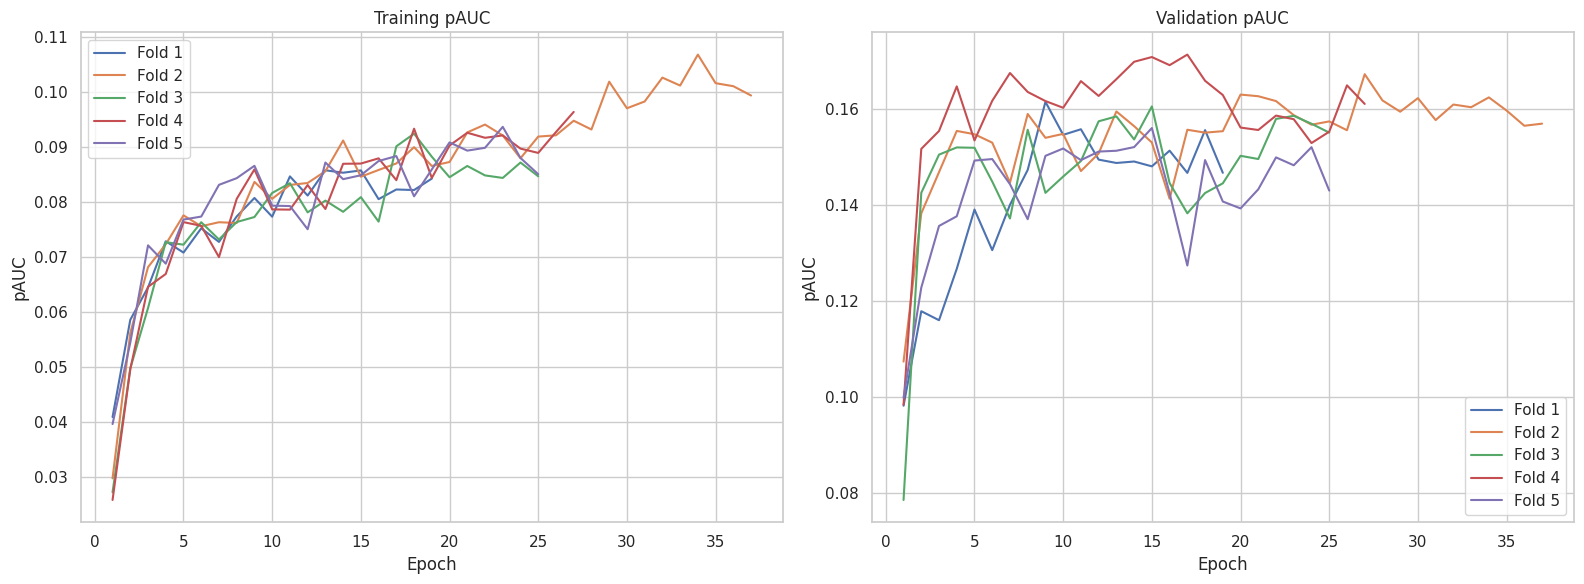

In [14]:
sns.set(style="whitegrid")

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.lineplot(x='epoch', y='train_pauc', hue='Fold', data=histories, ax=axes[0])
axes[0].set_title('Training pAUC')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('pAUC')
axes[0].legend(loc='best')

sns.lineplot(x='epoch', y='val_pauc', hue='Fold', data=histories, ax=axes[1])
axes[1].set_title('Validation pAUC')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('pAUC')
axes[1].legend(loc='best')

fig.tight_layout()
plt.show()

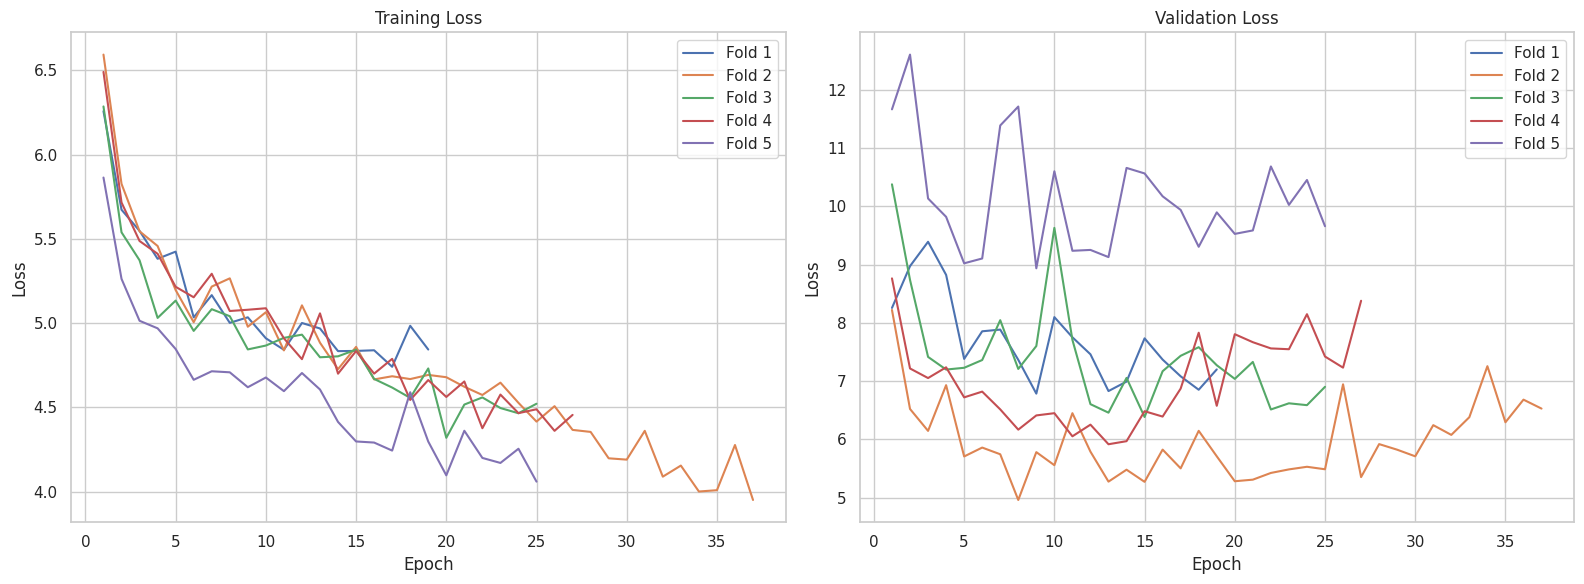

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.lineplot(x='epoch', y='train_loss', hue='Fold', data=histories, ax=axes[0])
axes[0].set_title('Training Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend(loc='best')

sns.lineplot(x='epoch', y='val_loss', hue='Fold', data=histories, ax=axes[1])
axes[1].set_title('Validation Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend(loc='best')

fig.tight_layout()
plt.show()